# Guitar Tab Extraction (prototype) - Dynamic prompting

In this workbook we will try to extract guitar tabs from a given pdf document. We will save this document as a picture and try to use gemini 2-5 flash multimodal capabilities to output the tabs. In a later step (which is not done here) one could use that to extract guitar tabs from videos, therefore efficiently creating tabulars

## Set up Gemini 2.5 flash

In [3]:
%%capture
%pip install langchain_google_genai

In [4]:
import google.generativeai as genai
import os
from langchain_google_genai import ChatGoogleGenerativeAI

api_key = os.environ.get("GOOGLE_API_KEY")
genai.configure(api_key=api_key)

os.environ["GOOGLE_API_KEY"] = api_key
llm25 = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature = 0)

In [3]:
from langchain_core.output_parsers import StrOutputParser
chain = llm25 | StrOutputParser()
print(chain.invoke("I How is it going?"))

It's going well, thank you! How about you?


Below you will see a screenshot of the pdf document containing guitar tabs from Queen - Don't stop me now.

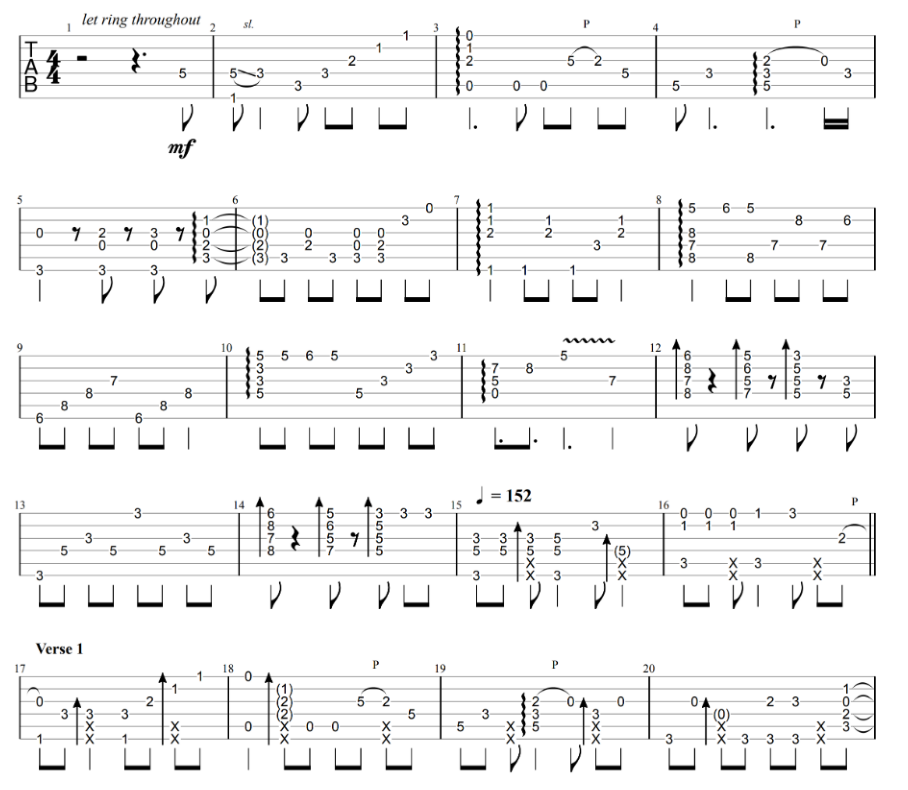

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

tab_test_path = './Don_t Stop me now - snapshot_full.png'

fig, axes = plt.subplots(1, 1, figsize=(20, 10))
img = mpimg.imread(tab_test_path)
axes.imshow(img)
axes.axis("off")
plt.show()

So the model should read in each individual measure (blocks seperated by vertical lines) and output the corresponding tabs. We define a pydantic basemodel for this to ensure correct parsing

In [6]:
from typing import List, Optional, Union
from pydantic import BaseModel, Field

class Strings(BaseModel):
    e: List[Optional[Union[int, str]]] = Field(description="Tabs on the higher E string.")
    B: List[Optional[Union[int, str]]] = Field(description="Tabs on the B string.")
    G: List[Optional[Union[int, str]]] = Field(description="Tabs on the G string.")
    D: List[Optional[Union[int, str]]] = Field(description="Tabs on the D string.")
    A: List[Optional[Union[int, str]]] = Field(description="Tabs on the A string.")
    E: List[Optional[Union[int, str]]] = Field(description="Tabs on the low E string.")

The following tool is a convenience tool which outputs the tabs in the correct format

In [7]:
def format_tab_horizontal(strings: Strings, min_columns: int = 4) -> str:
    # Correct order and explicit keys
    string_order = ["e", "B", "G", "D", "A", "E"]
    string_data = {
        "e": strings.e,
        "B": strings.B,
        "G": strings.G,
        "D": strings.D,
        "A": strings.A,
        "E": strings.E,
    }

    # Determine max number of columns needed
    max_notes = max(max(len(v) for v in string_data.values()), min_columns)

    # Determine max width needed per note
    all_notes = [str(n) for notes in string_data.values() for n in notes]
    max_note_len = max((len(note) for note in all_notes), default=1)

    note_spacing = max_note_len + 2
    total_width = (max_notes - 1) * note_spacing + max_note_len

    # Prepare empty tab lines
    lines = {k: ["-"] * total_width for k in string_order}

    # Fill frets
    for k in string_order:
        notes = string_data[k]
        for i, fret in enumerate(notes):
            fret_str = str(fret)
            pos = i * note_spacing
            for j, ch in enumerate(fret_str):
                if pos + j < total_width:
                    lines[k][pos + j] = ch

    # Build output
    return "\n".join(f"{k}|--{''.join(lines[k])}|" for k in string_order)

For example, the first few measures are

In [8]:
data = [Strings(e=[],B=[],G=[],D=[],A=[5],E=[]),
        Strings(e=["-","-","-","-","-",1],B=["-","-","-","-",1],G=["-","-","-",2],D=["5s3","-",3],A=["-",3],E=[1]),
        Strings(e=[0],B=[1],G=[2,"-","-","5p2"],D=["-","-","-","-",5],A=[0,0,0],E=[])]

example_string = ""
for i, j in enumerate(data):
    example_string += f"Measure {i + 1}:\n{format_tab_horizontal(j)}\n\n"

print(example_string)

Measure 1:
e|------------|
B|------------|
G|------------|
D|------------|
A|--5---------|
E|------------|

Measure 2:
e|---------------------------1--|
B|----------------------1-------|
G|-----------------2------------|
D|--5s3-------3-----------------|
A|-------3----------------------|
E|--1---------------------------|

Measure 3:
e|--0----------------------|
B|--1----------------------|
G|--2--------------5p2-----|
D|----------------------5--|
A|--0----0----0------------|
E|-------------------------|




Now that we have got the output formatting right, let us try to 0-shot the task

In [9]:
import base64
from typing import List
from langchain_core.messages import HumanMessage
from langchain.schema import HumanMessage

# function to encode an image to base64
def encode_image_to_base64(image_path: str) -> str:
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

# Encode the image
tab_encoded = encode_image_to_base64(tab_test_path)

# function to wrap llm input
def message(query: str) -> List[HumanMessage]:

    multimodal_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{tab_encoded}"
            }
        },
        {
            "type": "text",
            "text": query
        }
    ]

    return [HumanMessage(content=multimodal_content)]

In [14]:
from langchain_core.runnables import RunnableLambda

input = RunnableLambda(message) | llm25.with_structured_output(Strings) | StrOutputParser()
print(format_tab_horizontal(input.invoke(f"""Output all tabs in the first measure in this picture""")))

e|------------|
B|------------|
G|------------|
D|------------|
A|--5---------|
E|------------|


This actually worked quite well, but unfortunately the 2nd measure does not

In [15]:
from langchain_core.runnables import RunnableLambda

input = RunnableLambda(message) | llm25.with_structured_output(Strings) | StrOutputParser()
print(format_tab_horizontal(input.invoke(f"""Output all tabs in the second measure in this picture""")))

e|--------------------|
B|--1-----------------|
G|--2-----------------|
D|--3-----------------|
A|--5p3---------------|
E|--------------------|


## Dynamic prompting

What I mean by dynamic prompting is that in usual prompting, you give the llm examples and how to do things. However, another way of tackling problems is to lets the llm learn to things iteratively by letting it observe its own mistakes.

In [16]:
from typing import Literal, TypedDict, Annotated
import operator
import uuid

# import necessary modules
from langgraph.constants import END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

# Define the shared graph state
class State(TypedDict):
    llm_output: Annotated[List[str], operator.add] # store llm output as a list
    decission: str # decide whether to continue or not
    correction : Annotated[List[str], operator.add] # the correct tabs outputted
    measure_number : int # for reference

In [44]:
def generate_llm_output(state: State) -> State:
    measure_number = state.get("measure_number", 1)
    if measure_number == 1: # first measure need extra case as there is nothing to learn from
        output = llm25.with_structured_output(Strings).invoke([HumanMessage(content=[
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{tab_encoded}"
                }
            },
            {
                "type": "text",
                "text": "Output all tabs you see in this picture in the first measure."
            }
        ])])
        return {"llm_output" : [format_tab_horizontal(output)], "measure_number": measure_number + 1}
    else:
        measure_number_prev = measure_number - 1
        correction_text = ""
        for i, j in enumerate(state["correction"]):
            correction_text += f"Measure {i + 1}:\n{j}\n\n"

        llm_output_text = ""
        for i, j in enumerate(state["llm_output"]):
            llm_output_text += f"Measure {i + 1}:\n{j}\n\n"
        instruction_text = """The following will make you understand how to correctly read the tabs in the picture.

Your objective was to output all tabs in the first {measure_number_prev} measures in this picture.

You outputted the following:
{llm_output}
This is the correct output:
{correction}
Use this information to output all tabs you see in this picture in the subsequent measure {measure_number}.""".format(llm_output = llm_output_text, 
                                                                            correction = correction_text, 
                                                                            measure_number = state["measure_number"],
                                                                            measure_number_prev = measure_number_prev)
        print(instruction_text)        
        human_msg_correction = HumanMessage(
            content=[
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{tab_encoded}"
                    }
                },
                {
                    "type": "text",
                    "text": instruction_text
                }
            ]
        )
        output = llm25.with_structured_output(Strings).invoke([human_msg_correction])
        return {"llm_output": [format_tab_horizontal(output)], "measure_number": measure_number + 1}


# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Do you approve the following output?", # question to the user
        "llm_output": state["llm_output"]
    })

    if decision == "Y": # if the user approves the output
        return Command(goto="approved_path", update={"decision": "Y"})
    else: # if the user rejects the output
        return Command(goto="rejected_path", update={"decision": "N"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    decision = interrupt({""}) # input from the user to correct the output
    return {"correction" : decision}

In [45]:
# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", "generate_llm_output")

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

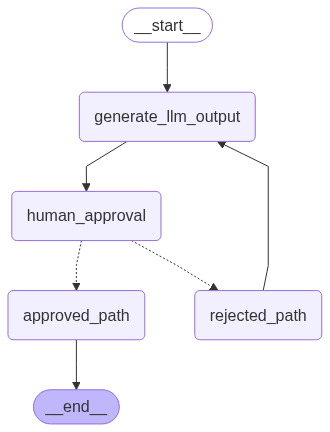

In [46]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Test

Here were are going to test the above defined graph with dynamic feedback. Each markdown defines an additional measure. We give solutions to 3 measures, but stop afterwards as the result it not the desired ones.

In [49]:
config = {"configurable": {"thread_id": uuid.uuid4()}} # define configuration with thread_id
result = graph.invoke({}, config=config)
print(result["__interrupt__"])
print(result["__interrupt__"][0].value["llm_output"][0])

[Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': ['e|------------|\nB|------------|\nG|------------|\nD|------------|\nA|--5---------|\nE|------------|']}, resumable=True, ns=['human_approval:dbb0c2c8-a788-bebe-01cd-eb3841560f69'])]
e|------------|
B|------------|
G|------------|
D|------------|
A|--5---------|
E|------------|


Even though the output was correct, we to resume by taking the "N" path and give the correct (same) output.

In [ ]:
graph.invoke(Command(resume="N"), config=config)
output_check = graph.invoke(Command(resume=[format_tab_horizontal(Strings(e=[],B=[],G=[],D=[],A=[5],E=[]))]), config=config)
print(output_check)

The following will make you understand how to correctly read the tabs in the picture.

Your objective was to output all tabs in the first 1 measures in this picture.

You outputted the following:
Measure 1:
e|------------|
B|------------|
G|------------|
D|------------|
A|--5---------|
E|------------|


This is the correct output:
Measure 1:
e|------------|
B|------------|
G|------------|
D|------------|
A|--5---------|
E|------------|


Use this information to output all tabs you see in this picture in the subsequent measure 2.


{'llm_output': ['e|------------|\nB|------------|\nG|------------|\nD|------------|\nA|--5---------|\nE|------------|',
  'e|------------|\nB|--1---------|\nG|------------|\nD|--5--3------|\nA|--3---------|\nE|------------|'],
 'correction': ['e|------------|\nB|------------|\nG|------------|\nD|------------|\nA|--5---------|\nE|------------|'],
 'measure_number': 3,
 '__interrupt__': [Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': ['e|------------|\nB|------------|\nG|------------|\nD|------------|\nA|--5---------|\nE|------------|', 'e|------------|\nB|--1---------|\nG|------------|\nD|--5--3------|\nA|--3---------|\nE|------------|']}, resumable=True, ns=['human_approval:6ea7824d-69c9-520a-0a67-ac5c060a1f5f'])]}

Give solution to the 2nd measure.

In [51]:
graph.invoke(Command(resume="N"), config=config)
output_check = graph.invoke(Command(resume=[format_tab_horizontal(Strings(e=["-","-","-","-","-",1],B=["-","-","-","-",1],G=["-","-","-",2],D=["5s3","-",3],A=["-",3],E=[1]))]), config=config)
print(output_check)

The following will make you understand how to correctly read the tabs in the picture.

Your objective was to output all tabs in the first 2 measures in this picture.

You outputted the following:
Measure 1:
e|------------|
B|------------|
G|------------|
D|------------|
A|--5---------|
E|------------|

Measure 2:
e|------------|
B|--1---------|
G|------------|
D|--5--3------|
A|--3---------|
E|------------|


This is the correct output:
Measure 1:
e|------------|
B|------------|
G|------------|
D|------------|
A|--5---------|
E|------------|

Measure 2:
e|---------------------------1--|
B|----------------------1-------|
G|-----------------2------------|
D|--5s3-------3-----------------|
A|-------3----------------------|
E|--1---------------------------|


Use this information to output all tabs you see in this picture in the subsequent measure 3.
{'llm_output': ['e|------------|\nB|------------|\nG|------------|\nD|------------|\nA|--5---------|\nE|------------|', 'e|------------|\nB|-

and finally to the third measure

In [52]:
print(graph.invoke(Command(resume="N"), config=config))
output_check = graph.invoke(Command(resume=[format_tab_horizontal(Strings(e=[0],B=[1],G=[2,"-","-","5p2"],D=["-","-","-","-",5],A=[0,0,0],E=[]))]), config=config)
print(output_check)

{'llm_output': ['e|------------|\nB|------------|\nG|------------|\nD|------------|\nA|--5---------|\nE|------------|', 'e|------------|\nB|--1---------|\nG|------------|\nD|--5--3------|\nA|--3---------|\nE|------------|', 'e|--0---------|\nB|--1---------|\nG|--2---------|\nD|--0---------|\nA|--0---------|\nE|--0---------|'], 'correction': ['e|------------|\nB|------------|\nG|------------|\nD|------------|\nA|--5---------|\nE|------------|', 'e|---------------------------1--|\nB|----------------------1-------|\nG|-----------------2------------|\nD|--5s3-------3-----------------|\nA|-------3----------------------|\nE|--1---------------------------|'], 'measure_number': 4, '__interrupt__': [Interrupt(value={''}, resumable=True, ns=['rejected_path:5f801cdc-c2bc-002d-a847-7dece7230df7'])]}
The following will make you understand how to correctly read the tabs in the picture.

Your objective was to output all tabs in the first 3 measures in this picture.

You outputted the following:
Measu

Unfortunately, it does not work as I hoped for.

# Ultralytics

Ultralytics provides ways to better unstand how multimodal llm understand pictures. It turns out that gemini has some real problems finding both pictures and measure, which is likely why it does not work. The source for these scripts are https://github.com/ultralytics/notebooks/blob/main/notebooks/how-to-use-google-gemini-models-for-object-detection-image-captioning-and-ocr.ipynb

In [6]:
%pip install -U -q google-genai ultralytics

import json

import cv2
import ultralytics
from google import genai
from google.genai import types
from PIL import Image
from ultralytics.utils.downloads import safe_download
from ultralytics.utils.plotting import Annotator, colors

ultralytics.checks()

Ultralytics 8.3.163  Python-3.12.7 torch-2.7.1+cpu CPU (Intel Core(TM) Ultra 7 258V)
Setup complete  (8 CPUs, 31.5 GB RAM, 140.5/951.6 GB disk)


In [7]:

# Initialize the Gemini client with your API key
client = genai.Client(api_key=api_key)


def inference(image, prompt, temp=0.5):
    """
    Performs inference using Google Gemini 2.5 Pro Experimental model.

    Args:
        image (str or genai.types.Blob): The image input, either as a base64-encoded string or Blob object.
        prompt (str): A text prompt to guide the model's response.
        temp (float, optional): Sampling temperature for response randomness. Default is 0.5.

    Returns:
        str: The text response generated by the Gemini model based on the prompt and image.
    """
    response = client.models.generate_content(
        model="gemini-2.5-flash-preview-05-20",  # or "gemini-2.5-pro-exp-03-25"
        contents=[prompt, image],  # Provide both the text prompt and image as input
        config=types.GenerateContentConfig(
            temperature=0,  # Controls creativity vs. determinism in output
        ),
    )

    return response.text  # Return the generated textual response

We start with a closeup of the first 4 tabs.

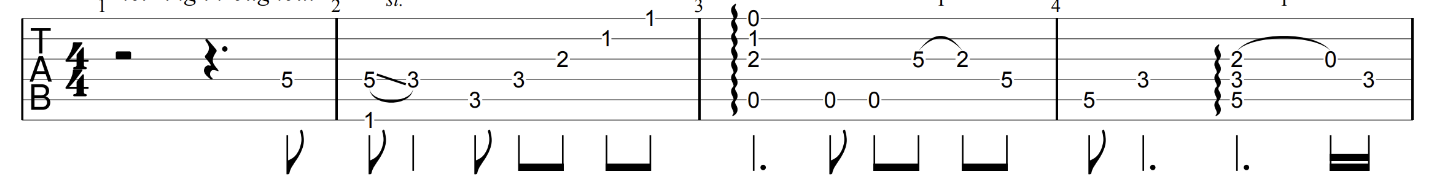

In [8]:
Image.fromarray(cv2.cvtColor(cv2.imread("./Don_t Stop me now - snapshot.png"), cv2.COLOR_BGR2RGB))

In [9]:
def read_image(image_name):

    # Read image with opencv
    image = cv2.cvtColor(cv2.imread(f"./{image_name}"), cv2.COLOR_BGR2RGB)

    # Extract width and height
    h, w = image.shape[:2]

    # # Read the image using OpenCV and convert it into the PIL format
    return Image.fromarray(image), w, h

In [11]:
def clean_results(results):
    """Clean the results for visualization."""
    return results.strip().removeprefix("```json").removesuffix("```").strip()

We start by asking gemini to detect measures.

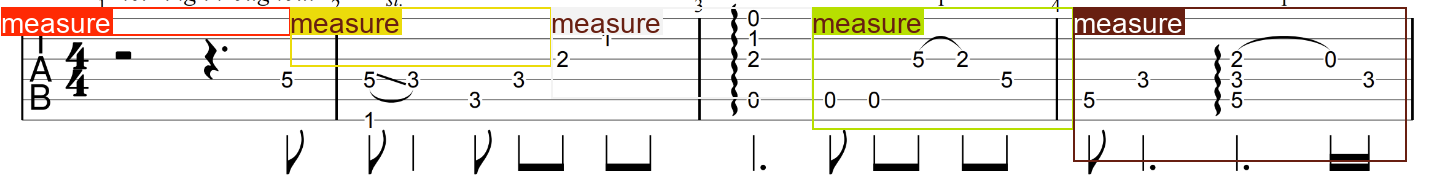

In [18]:
# Define the text prompt
prompt = """
Detect the 2d bounding boxes of all measures in this tabluar.
"""

# Fixed, plotting function depends on this.
output_prompt = "Return just box_2d and labels, no additional text."

image, w, h = read_image("Don_t Stop me now - snapshot.png")  # Read img, extract width, height

results = inference(image, prompt + output_prompt)  # Perform inference

cln_results = json.loads(clean_results(results))  # Clean results, list convert

annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, item in enumerate(cln_results):
    # By default, gemini model return output with y coordinates first.
    # Scale normalized box coordinates (0–1000) to image dimensions
    y1, x1, y2, x2 = item["box_2d"]  # bbox post processing,
    y1 = y1 / 1000 * h
    x1 = x1 / 1000 * w
    y2 = y2 / 1000 * h
    x2 = x2 / 1000 * w

    if x1 > x2:
        x1, x2 = x2, x1  # Swap x-coordinates if needed
    if y1 > y2:
        y1, y2 = y2, y1  # Swap y-coordinates if needed

    annotator.box_label([x1, y1, x2, y2], label=item["label"], color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

We see that the first two detection are a complete fail, while the 3 third is almost correct and the 4th is 100% correct. Instead of asking for measure, we can also ask for detection of numbers, which I think would be a more simple task. Turns out that gemini has just as much problems with that.

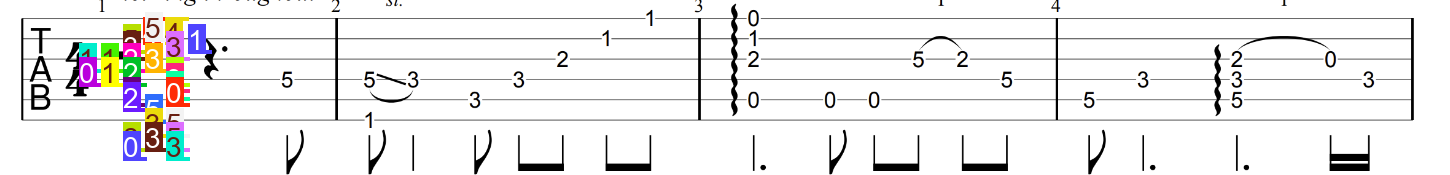

In [19]:
# Define the text prompt
prompt = """
Detect the 2d bounding boxes of all numbers in this tabluar.
"""

# Fixed, plotting function depends on this.
output_prompt = "Return just box_2d and labels, no additional text."

image, w, h = read_image("Don_t Stop me now - snapshot.png")  # Read image and extract width, height

results = inference(image, prompt + output_prompt)

# Clean the results and load results in list format
cln_results = json.loads(clean_results(results))

annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, item in enumerate(cln_results):
    # By default, gemini model return output with y coordinates first.
    # Scale normalized box coordinates (0–1000) to image dimensions
    y1, x1, y2, x2 = item["box_2d"]  # bbox post processing,
    y1 = y1 / 1000 * h
    x1 = x1 / 1000 * w
    y2 = y2 / 1000 * h
    x2 = x2 / 1000 * w

    if x1 > x2:
        x1, x2 = x2, x1  # Swap x-coordinates if needed
    if y1 > y2:
        y1, y2 = y2, y1  # Swap y-coordinates if needed

    annotator.box_label([x1, y1, x2, y2], label=item["label"], color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output